# Project 2 
### Student Name: Ricky Martin
### Student PID: A13810245

#### Due: Mar 15 at 11:59pm

#### Goal is to implement 2 algorithms for solving a problem of choice.

#### To Dos: 
    Upload to Github
    Have a READ ME file that provides guide to run code
    provide github link in final report
    
#### Sources that helped with Code:
    
    * TA: Dan Acosta-Kane
            Helped with the Skeleton Code from previous Homeworks in properly 
            implementing a Dyna Q Algorithm.
    * Sentdex on Youtube: 
            Help with the Robotic Arm manipulation as well as UARM Swift Pro 2 API 
            access.
            link: https://www.youtube.com/watch?v=gRzqsW9Rj3E
    * Dr. Danieal Soper on Youtube:
            Help with inspiration for the project as well as implementation. All code 
            provided in this Document is my own, I simply used his video for inspiration
            and some guidance.
            link: https://www.youtube.com/watch?v=iKdlKYG78j4
            
#### The provided Notebook will be split into two parts:

    * Part 1: Q-Learning Algorithm vs. Dyna Q Algorithm
            This Section will go over the state and implementation of a maze that is to 
            be manuevered through by the agents.
    * Part 2: Robotic Arm implementation
            This section will be where we use the q-values of the trained models to 
            operate a real robotic arm through the maze.

## Part 1: Reinforcement Learning 

### Imports

In [1]:
# Regular imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tracking Progress
from tqdm import tqdm

# Visualizing Environment
import heapq
from scipy.signal import convolve as conv

### Create Environment

In [2]:
# Environment Creation: This state offers complications/barriers but should be a good 
#              showcase for the abilities of Q-Learning and Dyna Q. The all black boxes 
#              Represent a -100 Reward because in places where a robot operates there 
#              may not be room for 'redirection' the agent will need to understand there 
#              could be walls or obstructions and there for the agent cannot pass into 
#              certain areas and expect a redirection.

def create_env(n):
    
    b = int(-100) # bad areas
    I = int(-1)   # path
    O = int(100)  # goal
    
    environment = [[b,b,b,b,b,b,b,b,b,b,b],
                   [b,I,I,I,I,I,I,I,I,I,b],
                   [b,I,b,I,b,I,b,I,b,I,b],
                   [b,I,b,I,b,O,b,I,b,I,b],
                   [b,I,b,I,I,b,I,I,b,I,b],
                   [b,b,I,I,I,I,I,I,I,b,b],
                   [b,I,I,b,b,b,b,b,I,I,b],
                   [b,I,I,I,I,I,I,I,I,I,b],
                   [b,b,I,b,b,I,b,b,I,b,b],
                   [b,I,I,I,I,b,I,I,I,I,b],
                   [b,b,b,b,b,b,b,b,b,b,b]]
    
    # Different Ways of implementation, kept for editing purposes
    #environment = [[-10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10],
     #              [-10,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10],
      #             [-10, -10,  -1,  -1, -10,  -1, -10,  -1,  -1, -10, -10],
       #            [-10, -10, -10,  -1, -10,  10, -10,  -1, -10, -10, -10],
        #           [-10, -10, -10,  -1,  -1, -10,  -1,  -1, -10, -10, -10],
         #          [-10, -10,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10, -10],
          #         [-10,  -1,  -1, -10, -10, -10, -10,  -10,  -1, -1, -10],
           #        [-10,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10],
            #       [-10, -10,  -1, -10, -10,  -1, -10, -10,  -1, -10, -10],
             #      [-10,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10],
              #     [-10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10]]
    
    # Different Environment to test
    #environment = [[-10, -10, -10, -10, -10,  10, -10, -10, -10, -10, -10],
     #              [-10,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10],
      #             [-10, -10,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10, -10],
       #            [-10, -10, -10,  -1,  -1,  -1, -10, -10, -10, -10, -10],
        #           [-10, -10, -10,  -1,  -1,  -1,  -1,  -1, -10, -10, -10],
         #          [-10, -10, -10, -10, -10,  -1,  -1,  -1, -10, -10, -10],
          #         [-10, -10,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10, -10],
           #        [-10,  -1,  -1,  -1, -10, -10, -10,  -1,  -1,  -1, -10],
            #       [-10,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10],
             #      [-10,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1, -10],
              #     [-10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10]]
            
    # actions: what direction the agent will move
    actions = ['up', 'right', 'down', 'left']
    
    # for graphing purposes, did this for color
    env_list = []
    for row in np.array(environment):
        env_list.append(row*-1)

    # Display the maze better with a cmap display
    plt.figure(figsize=(10, 10))
    plt.imshow(env_list, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()
            
    return np.array(environment), actions

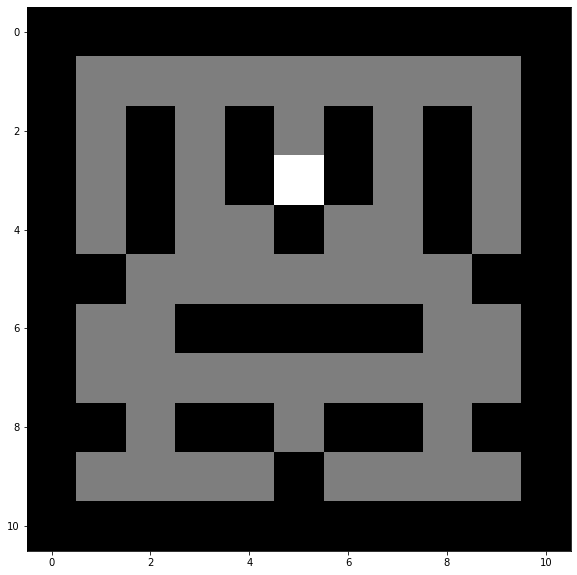

In [3]:
# Create an environment: I matched this with real world sizing. Later we will see my 
#             real world implementation takes up a 9x9 space, however this is due to the
#             11x11 being made up of imaginary walls.


grid_n = 11 
env, actions = create_env(grid_n)

In [4]:
# For Later Use
ls = [[5,5],[5,4],[9,1],[4,9],[1,1],[1,4],[9,3],[6,9],[9,6],[5,8]]

### Helper Functions

In [5]:
# Get the starting state which is a randomly selected block that is not an edge or goal
def start(n, env):
    row = np.random.randint(n)
    col = np.random.randint(n)

    # Run through random states until we find a spot we can work on
    while env[row, col] != -1:
        row = np.random.randint(n)
        col = np.random.randint(n)  
    
    # return starting state
    state = row,col
    return state

# Get the next state acording to the action selected
def next_state(state, action):
    
    # Get row and coloumn state
    row = state[0]
    col = state[1]
    
    # Move according to action
    if actions[action] == 'up' and col > 0:
        row -= 1
    elif actions[action] == 'right' and row < grid_n - 1:
        col -= 1
    elif actions[action] == 'down' and col < grid_n - 1:
        row += 1
    elif actions[action] == 'left' and row > 0:
        col += 1
        
    # return new state
    new_state = row,col
    return new_state

# Get the next action utilizing e-greedy exploration
# Utilizes Q values
def next_action(state, epsilon, values):
    
    # actions: what direction the agent will move
    actions = ['up', 'right', 'down', 'left']
    
    # e-greedy exploration, go with q-value location aka: location of action
    if np.random.random() < epsilon:
        return np.argmax(values[state])
    else: 
        return np.random.randint(len(actions))   

### Testing State-Action is working Correctly

In [6]:
def create_env_test(n):
    
    b = int(-10) # bad areas
    I = int(-1)   # path
    O = int(10)  # goal
    
    environment = [[b,b,b,b,b,b,b,b,b,b,b],
                   [b,I,I,I,I,I,I,I,I,I,b],
                   [b,I,b,I,b,I,b,I,b,I,b],
                   [b,I,b,I,b,O,b,I,b,I,b],
                   [b,I,b,I,I,b,I,I,b,I,b],
                   [b,b,I,I,I,I,I,I,I,b,b],
                   [b,I,I,b,b,b,b,b,I,I,b],
                   [b,I,I,I,I,I,I,I,I,I,b],
                   [b,b,I,b,b,I,b,b,I,b,b],
                   [b,I,I,I,I,b,I,I,I,I,b],
                   [b,b,b,b,b,b,b,b,b,b,b]]

    # actions: what direction the agent will move
    actions = ['up', 'right', 'down', 'left']
    
    # for graphing purposes, did this for color
    env_list = []
    for row in np.array(environment):
        env_list.append(row*-1)

    # Display the maze better with a cmap display
    plt.figure(figsize=(5, 5))
    plt.imshow(env_list, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()
            
    return np.array(environment), actions

# Graphs current iteration of the Environment
def graph_env(env, state):
    testenv = env
    testenv[state] = 0
    
    # for graphing purposes, multiplying by -1 to make a better graph
    env_list = []
    for row in np.array(testenv):
        env_list.append(row*-1)

    # Display the maze better with a cmap display
    plt.figure(figsize=(5, 5))
    plt.imshow(env_list, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

#### Test environment

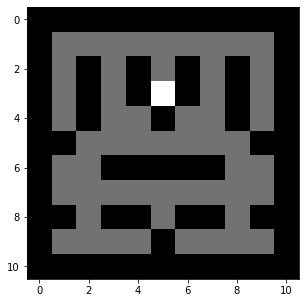

In [8]:
epsilon = .8

# Define Empty Q-value list aka: state action pair list
q_values = np.zeros((grid_n, grid_n, len(actions)))

# call create env again to make a new graphing showcase
grid_n = 11
env_t, actions = create_env_test(grid_n)

#### Test Start State

Starting state: (9, 1)


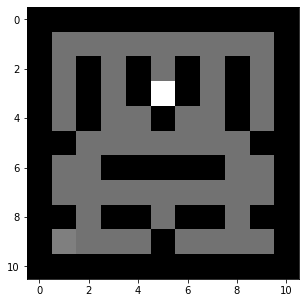

In [9]:
# Get initial state then graph it
state = start(grid_n, env_t)
print('Starting state:', state)
graph_env(env_t, state)

#### Test Next Action

In [10]:
# Get random action associated with the state
a = next_action(state, epsilon, q_values)
print('Action Template: 0 = up, 1 = right, 2 = down, 3 = left')
print('Action:', a)

Action Template: 0 = up, 1 = right, 2 = down, 3 = left
Action: 0


#### Test Next State

State Prime: (8, 1)


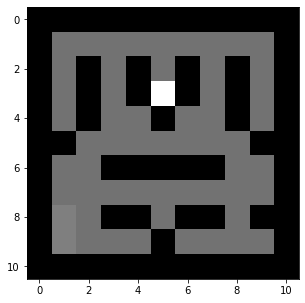

In [11]:
# Get S' for the s/a pair
new_state = next_state(state, a)
print('State Prime:', new_state)
graph_env(env_t, new_state)

#### Test Reward

In [12]:
# Get the reward associate with the state
r = env[state[0],state[1]]
r_p = env[new_state[0],new_state[1]]
print('Reward for state:',r)
print('Reward for state prime:', r_p)
print('Reward so far:',r+r_p)

Reward for state: -1
Reward for state prime: -100
Reward so far: -101


## RL Models

In [13]:
def run_episode_q(env, q_values, alpha, gamma, ep, max_steps):
    
    #run through 1000 training episodes
    for t in range(max_steps):
        
        # Get Starting State, INITIALIZE S
        state = start(grid_n, env)
        row, col = state
        
        # Iterate while in the path, if the path is broken, stop
        while env[state] == -1:
            
            # CHOSE A FROM S USING POLICY DERIVED FROM Q
            # Select action according to epsilon greedy Exploration
            a = next_action(state, ep, q_values)
            
            # Define old state
            p_state = state
            p_row, p_col = row, col
            
            # TAKE ACTION A, OBSERVE R, S'
            # Get New State
            state = next_state(state, a)
            row, col = state
            
            # Get Reward associated with state
            r = env[state]
            
            # UPDATE and APPLY Q-LEARNING
            update = r + (gamma * np.max(q_values[row, col])) - q_values[p_row, p_col, a]
            q_values[p_row, p_col, a] = q_values[p_row, p_col, a] + (alpha * update)
            
    return q_values

In [14]:
##########################################################################################

In [15]:
def run_episode_dynaQ(env, qp_values, model, alpha, gamma, epsilon, n_planning_steps, max_steps):
    
    # run through 1000 training episodes
    for t in range(max_steps):
        
        # Get Starting State, INITIALIZE S, NONTERMINAL STATE
        state = start(grid_n, env)
        row, col = state
        
        while env[state] == -1:
            # CHOOSE A FROM S USING POLICY E-Greedy
            a = next_action(state, epsilon, qp_values)
            
            # Define old state
            p_state = state
            p_row, p_col = row, col
            
            # TAKE ACTION A, OBSERVE R, S'
            # Get New State
            state = next_state(state, a)
            row, col = state
            
            # Get Reward associated with state
            r = env[state]
            
            # UPDATE and APPLY Q-LEARNING
            update = r + (gamma * np.max(qp_values[row, col])) - qp_values[p_row, p_col, a]
            qp_values[p_row, p_col, a] = qp_values[p_row, p_col, a] + (alpha * update)

            # MODEL UPDATE
            model[p_row, p_col, a] = [row, col, r]

            # LOOP REPEAT N TIMES
            for k in range(n_planning_steps):

                # Create an array of the candidate states to update
                candidates = np.array(np.where(~np.isnan(model[:,:,:,0]))).T 

                # RANDOM INDEX
                idx = np.random.choice(len(candidates))

                # RANDOMLY OBSERVED STATE AND ACTION
                row_p, col_p, a_p = candidates[idx]

                # Use your model to find the next state and reward
                next_row_p, next_col_p, r_p = model[row_p, col_p, a_p]

                # Update q values using q learning
                update_p = r_p + (gamma * np.max(qp_values[int(next_row_p), int(next_col_p)])) - qp_values[row_p, col_p, a_p]
                qp_values[row_p, col_p, a_p] = qp_values[row_p, col_p, a_p] + (alpha * update_p)

    return qp_values, model

In [16]:
##########################################################################################

## Run RL 

In [17]:
alpha = 0.5
gamma = 0.8
epsilon = 0.9
n_planning_steps= [0,1,10,20]
n_episodes = 50
n_experiments = 2 
max_steps = 1000

q_values = []
qp_values = []

In [18]:
print('Q-Learning Training start...')

for i in tqdm(range(n_experiments)):

    # Stores model of reward and next state
    q_values = np.zeros((grid_n, grid_n, len(actions)))
    
    # Run Q on an episode of GridWorld
    q_values = run_episode_q(env, q_values, alpha, gamma, epsilon, max_steps) 

print('Q-Learning Training Finished')
print('')

 50%|█████     | 1/2 [00:00<00:00,  8.35it/s]

Q-Learning Training start...


100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

Q-Learning Training Finished



In [19]:
print('Dyna Q Training start ...')

for i , k_steps in tqdm(enumerate(n_planning_steps)):
    
    for j in range(n_experiments):
        
        # Stores model of reward and next state
        model = np.nan*np.zeros((grid_n, grid_n, len(actions), 3))
        qp_values = np.zeros((grid_n, grid_n, len(actions)))

        #print(model.shape)
        for l in range(n_episodes):

            # Run DynaQ on an episode of GridWorld
            qp_values, model = run_episode_dynaQ(env, qp_values, model, alpha, gamma, epsilon, k_steps, max_steps) 

print('Q-Learning Training Finished')

0it [00:00, ?it/s]

Dyna Q Training start ...


4it [13:57, 209.26s/it]

Q-Learning Training Finished


## Grapher Functions

In [26]:
def plot_quiver(env, value, grid_n):
    """
    Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
    """
    
    x = np.arange(0,grid_n)
    y = np.arange(0,grid_n)
    X, Y = np.meshgrid(x, y)
    
    a_max = []
    for i, row in enumerate(value):
        for j in row:
            a_max.append(j.argmax())
            
    a_max = np.reshape(np.array(a_max), (grid_n,grid_n))
    a_max = a_max[::-1,:]
    print(a_max)
    U = np.zeros(X.shape)
    V = np.zeros(Y.shape)
    U[a_max == 3] = 1
    V[a_max == 2] = -1
    U[a_max == 1] = -1
    V[a_max == 0] = 1

    plt.quiver(X, Y, U, V)

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 1 1 0 3 3 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 1 1 1 3 3 0 1 0]
 [0 3 0 0 0 0 0 0 0 1 0]
 [0 0 3 0 0 1 3 0 1 0 0]
 [0 0 0 0 1 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 3 3 3 3 2 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


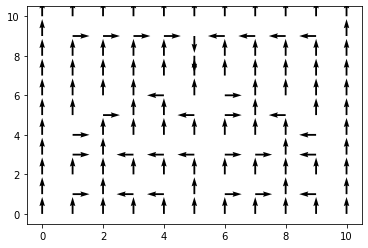

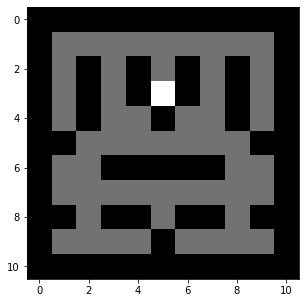

In [27]:
# Q-Learning Grid
grid_n = 11
plot_quiver(env, q_values,grid_n)
env_t, actions = create_env_test(grid_n)

[[0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 1 1 0 3 3 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 3 3 0 0 0]
 [0 3 0 0 0 0 0 0 0 1 0]
 [0 0 3 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 3 3 3 3 2 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


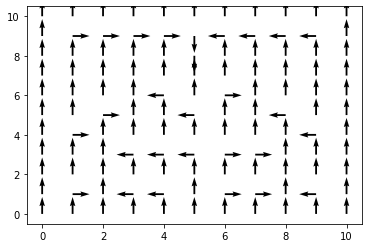

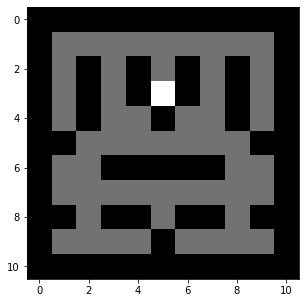

In [28]:
# Dyna Q Learning Grid
grid_n = 11
plot_quiver(env, qp_values, grid_n)
env_t, actions = create_env_test(grid_n)

## Path Helper Function

In [29]:
def get_path_q(row_ind, col_ind, q_values):
    
    state = row_ind, col_ind
    if env[state] != -1:
        return []
    else:
        row, col = state
        path = []
        path.append([state])
        while env[state] == -1:
            action = next_action(state, 1.,q_values)
            state = next_state(state, action)
            path.append([state])
        return path
    
def get_path_dynaq(row_ind, col_ind, qp_values):
    
    state = row_ind, col_ind
    if env[state] != -1:
        return []
    else:
        row, col = state
        path = []
        path.append([state])
        while env[state] == -1:
            action = next_action(state, 1., qp_values)
            state = next_state(state, action)
            path.append([state])
        return path

## Get Path

In [30]:
def path_test(alg,values,ls):
    length = 0
    target = 0
    if alg == 'Q':
        for i, row in enumerate(ls):
            
            if i == 0:
                print('Testing Q-Learning:')
            path = get_path_q(row[0], row[1], values)
            if path[-1] == [(3,5)]:
                target += 1
            print('Test{0}:'.format(i),'Length of Path:',len(path),'Path:',path)
            length += len(path)
    if alg == 'D':
        for i, row in enumerate(ls):
            if i == 0:
                print('Testing Dyna-Q:')
            path = get_path_dynaq(row[0], row[1], values)
            if path[-1] == [(3,5)]:
                target += 1
            print('Test{0}:'.format(i),'Length of Path:',len(path),'Path:',path)
            length += len(path)
    
    return length, target

In [31]:
ls = [[5,5],[5,4],[9,1],[4,9],[1,1],[1,4],[9,3],[6,9],[9,6],[5,8]]

testQ,targetQ = path_test('Q', q_values, ls)
print('')
print('Final Verdict for Q-Learing:',testQ,'Correct out of 10:',targetQ)
print('')
print('')

testD,targetD = path_test('D', qp_values, ls)
print('')
print('Final Verdict for Dyna-Q:',testD,'Correct out of 10:',targetD)

Testing Q-Learning:
Test0: Length of Path: 11 Path: [[(5, 5)], [(5, 4)], [(4, 4)], [(4, 3)], [(3, 3)], [(2, 3)], [(1, 3)], [(1, 4)], [(1, 5)], [(2, 5)], [(3, 5)]]
Test1: Length of Path: 10 Path: [[(5, 4)], [(4, 4)], [(4, 3)], [(3, 3)], [(2, 3)], [(1, 3)], [(1, 4)], [(1, 5)], [(2, 5)], [(3, 5)]]
Test2: Length of Path: 15 Path: [[(9, 1)], [(9, 2)], [(8, 2)], [(7, 2)], [(6, 2)], [(5, 2)], [(5, 3)], [(4, 3)], [(3, 3)], [(2, 3)], [(1, 3)], [(1, 4)], [(1, 5)], [(2, 5)], [(3, 5)]]
Test3: Length of Path: 10 Path: [[(4, 9)], [(3, 9)], [(2, 9)], [(1, 9)], [(1, 8)], [(1, 7)], [(1, 6)], [(1, 5)], [(2, 5)], [(3, 5)]]
Test4: Length of Path: 7 Path: [[(1, 1)], [(1, 2)], [(1, 3)], [(1, 4)], [(1, 5)], [(2, 5)], [(3, 5)]]
Test5: Length of Path: 4 Path: [[(1, 4)], [(1, 5)], [(2, 5)], [(3, 5)]]
Test6: Length of Path: 15 Path: [[(9, 3)], [(9, 2)], [(8, 2)], [(7, 2)], [(6, 2)], [(5, 2)], [(5, 3)], [(4, 3)], [(3, 3)], [(2, 3)], [(1, 3)], [(1, 4)], [(1, 5)], [(2, 5)], [(3, 5)]]
Test7: Length of Path: 12 Path:

### Fully Testing the environment

In [32]:
tested_Q = 0
target_Q = 0

tested_D = 0
target_D = 0

for i in range(0, grid_n):
    for j in range(0, grid_n):
        if env[i,j] == -1:
            path_q = get_path_q(i, j, q_values)
            path_d = get_path_dynaq(i, j, qp_values)
    
            tested_Q += len(path_q)
            tested_D += len(path_d)
            
            if path_q[-1] == [(3,5)]:
                target_Q += 1
                
            if path_d[-1] == [(3,5)]:
                target_D += 1
                
print('Final Verdict:')
print('Q-Learning Scored:', tested_Q, 'and hit target:',target_Q,'out of 55 states')
print('DynaQ Scored:', tested_D, 'and hit target:',target_D,'out of 55 states')

Final Verdict:
Q-Learning Scored: 559 and hit target: 55 out of 55 states
DynaQ Scored: 559 and hit target: 55 out of 55 states


Final Verdict: This was a close race but the Dyna-Q implementation won due to one quicker route. I was expecting this because although Q-Learning is far less computationally expensive, the planning done by the Dyna-Q model should always out perform Q-Learning.

In [33]:
# Defining best algorithm to use for robot
values = qp_values

### Use RL System no Robot

In [34]:
def move(path, env_testing):
    cnt = 0
    
    # Move through Path
    print(path)
    for i in path:

        # Always starts at home
        if cnt == 0:
            print('Starting...')

        print('row:',i[0][0],'  col:',i[0][1])
        
        # show graph of state
        state = i[0][0],i[0][1]
        graph_env(env_testing, state)
        
        # if cnt = 0, pick up goal cube
        if cnt == 0:
            print('pickup')
            
        # if cnt = end, drop off goal cube
        if cnt == len(path) - 1:
            print('dropoff and end')
            
        cnt+=1

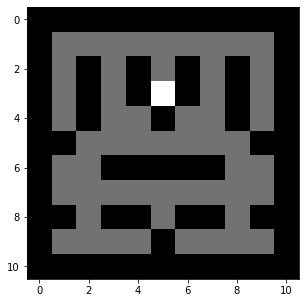

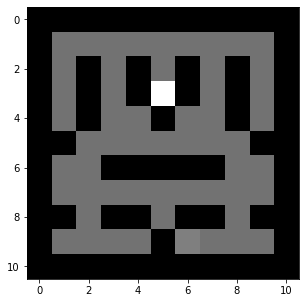

[[(9, 6)], [(9, 7)], [(9, 8)], [(8, 8)], [(7, 8)], [(6, 8)], [(5, 8)], [(5, 7)], [(4, 7)], [(3, 7)], [(2, 7)], [(1, 7)], [(1, 6)], [(1, 5)], [(2, 5)], [(3, 5)]]
Starting...
row: 9   col: 6


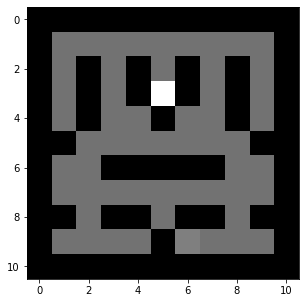

pickup
row: 9   col: 7


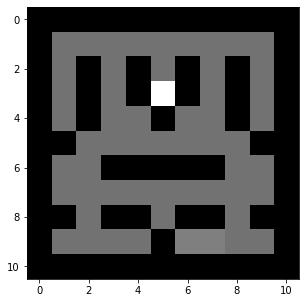

row: 9   col: 8


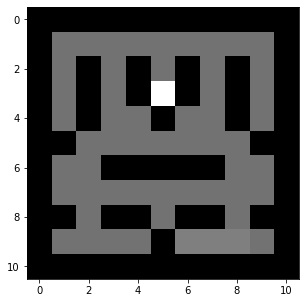

row: 8   col: 8


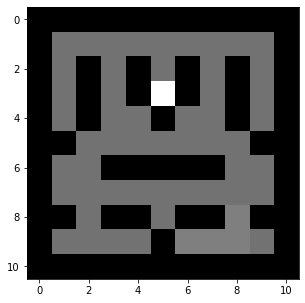

row: 7   col: 8


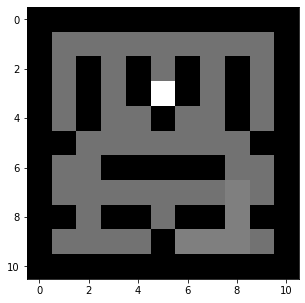

row: 6   col: 8


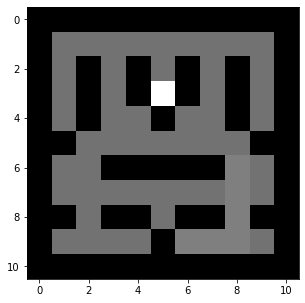

row: 5   col: 8


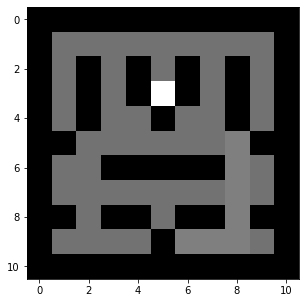

row: 5   col: 7


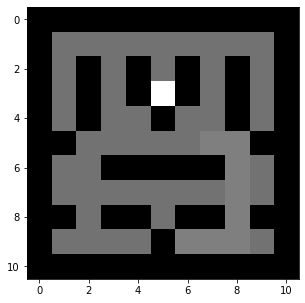

row: 4   col: 7


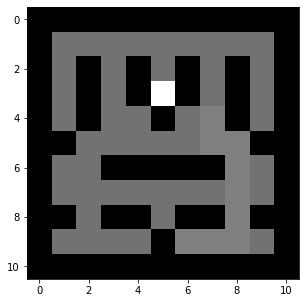

row: 3   col: 7


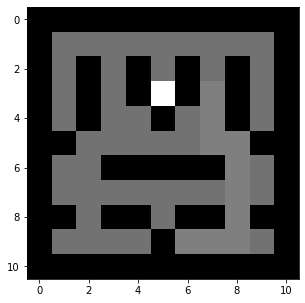

row: 2   col: 7


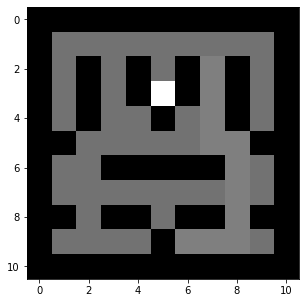

row: 1   col: 7


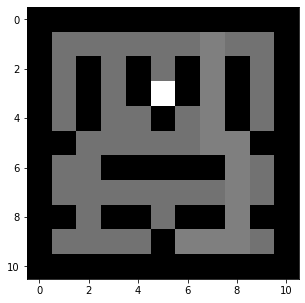

row: 1   col: 6


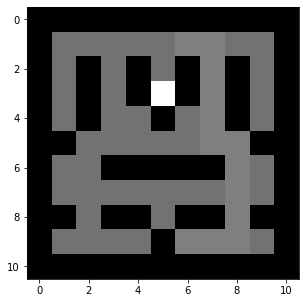

row: 1   col: 5


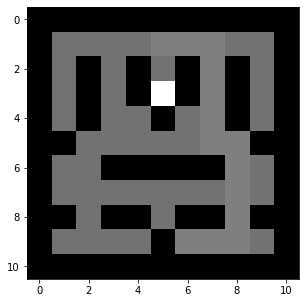

row: 2   col: 5


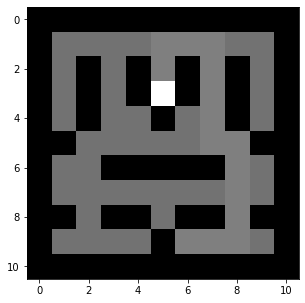

row: 3   col: 5


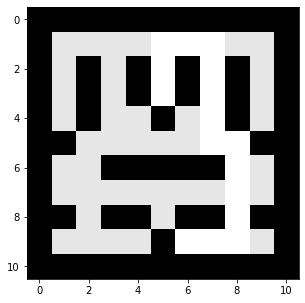

dropoff and end


In [35]:
start = [9,6]

# call create env again to make a new graphing showcase
grid_n = 11
env_testing, actions = create_env_test(grid_n)

state = start[0], start[1]
graph_env(env_testing, state)

# get path
path = get_path_q(start[0], start[1], values)

# go through path
move(path, env_testing)

# Part 2: Robot Arm Control

In [36]:
# Watch the video linked in the introduction that will show the instalation process

In [37]:
# Time Function and UARM API
import time
from uarm.wrapper.swift_api import SwiftAPI
import serial

In [46]:
# For Access Purposes, allows for access of port exception handleing
print("checking com exceptions...")
accessed = False
while not accessed:
    try:
        swift = SwiftAPI()
        accessed = True
    except Exception as e:
        print(str(e))
        time.sleep(0.2)
        
print('Device Info: ')
print(swift.get_device_info())

checking com exceptions...
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
can not found port, please connect the port via usb
Device Info: 
{'device_type': None, '

## The Set UP
As You can see I 3d Printed the environment and made it in the real world. With each square being 18x18 mm

In [47]:
from PIL import Image
import IPython.display as display

def image(my_image):
    img = Image.open('img/{0}.jpg'.format(my_image))
    display.display(img.transpose(Image.ROTATE_270))

In [ ]:
# Unran snippet of code because it made file too big, these are pictures of the environment provided
grid_n = 11 
env_show, actions = create_env(grid_n)

img1 = 'IMG_6470'
image(img1)

img2 = 'IMG_6473'
image(img2)

img3 = 'IMG_6471'
image(img3)

## Moving the Robot Along the Path

In [49]:
# Home Function allows for a Reset when needed

def home():
    swift.flush_cmd()
    swift.set_position(x=100, y=-80, z=80, speed=1000000)
    swift.set_position(x=100, y=-80, z=20, speed=1000000)
    swift.set_pump(False)

In [50]:
home()

In [56]:
def move_bot(path, env_testing):
    cnt = 0

    home()
    time.sleep(5)

    # Adhoc coding, I know this is frowned upon but for now it made things easier
    start_row = 150
    start_col = -80
    start_z = 40

    # Move through Path
    print(path)
    for i in path:

        # Always starts at home
        if cnt == 0:
            print('Starting...')
            swift.set_position(x=100, y=-80, z=80, speed=1000000)

        print('row:',i[0][0],'  col:',i[0][1])

        # Update x,y,z when needed
        x = start_row
        y = start_col
        z = start_z

        # Very Adhoc positioning again, but it made things easier for now
        X = x + 160 - (i[0][0]*19.4)    # ex. x = 1: x=200
        Y = -(y + (i[0][1]*19.45))      # ex. y = 1: y=-40
        Z = start_z

        # print location
        print('X:', X, '  Y:',Y, '  Z:', Z)
        swift.set_position(x=X, y=Y, z=Z, speed=1000000)
        
        state = i[0][0],i[0][1]
        graph_env(env_testing, state)
        
        # wait 1 second
        time.sleep(1)    

        # if cnt = 0, pick up goal cube
        if cnt == 0:
            print('pickup')
            swift.set_pump(True)
            swift.set_position(x=X, y=Y, z=Z-30, speed=1000000)
            time.sleep(4)
            swift.set_position(x=X, y=Y, z=Z, speed=1000000)
            time.sleep(1)
            
        # if cnt = end, drop off goal cube
        if cnt == len(path) - 1:
            print('dropoff and end')
            swift.set_position(x=X, y=Y, z=Z-25, speed=1000000)
            time.sleep(2)
            swift.set_pump(False)
            swift.set_position(x=X, y=Y, z=Z, speed=1000000)
            time.sleep(1)
            home()

        cnt+=1

### Bring To Drop Off Zone

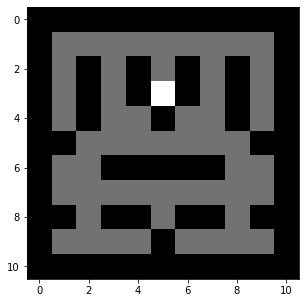

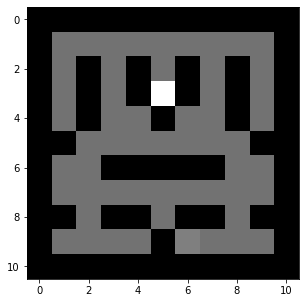

[[(9, 6)], [(9, 7)], [(9, 8)], [(8, 8)], [(7, 8)], [(6, 8)], [(5, 8)], [(5, 7)], [(4, 7)], [(3, 7)], [(2, 7)], [(1, 7)], [(1, 6)], [(1, 5)], [(2, 5)], [(3, 5)]]
Starting...
row: 9   col: 6
X: 135.4   Y: -36.69999999999999   Z: 40


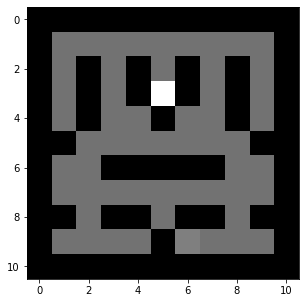

pickup
row: 9   col: 7
X: 135.4   Y: -56.150000000000006   Z: 40


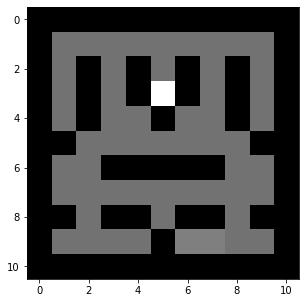

row: 9   col: 8
X: 135.4   Y: -75.6   Z: 40


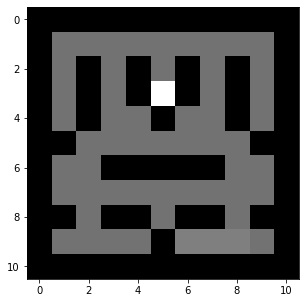

row: 8   col: 8
X: 154.8   Y: -75.6   Z: 40


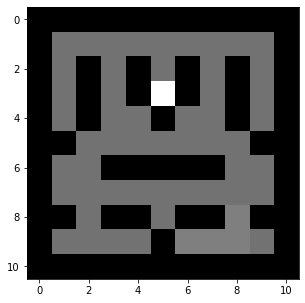

row: 7   col: 8
X: 174.20000000000002   Y: -75.6   Z: 40


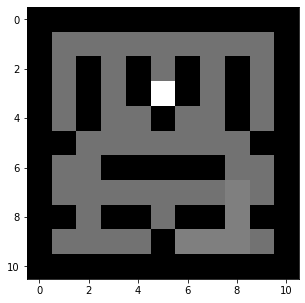

row: 6   col: 8
X: 193.60000000000002   Y: -75.6   Z: 40


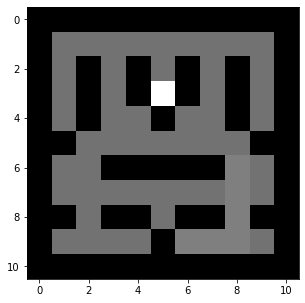

row: 5   col: 8
X: 213.0   Y: -75.6   Z: 40


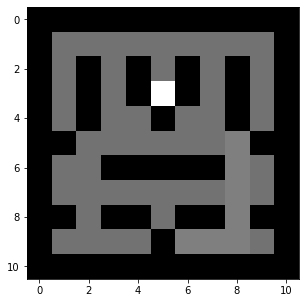

row: 5   col: 7
X: 213.0   Y: -56.150000000000006   Z: 40


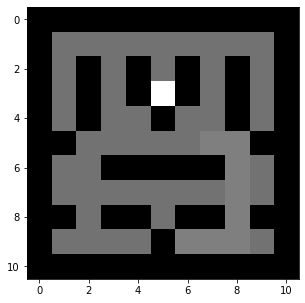

row: 4   col: 7
X: 232.4   Y: -56.150000000000006   Z: 40


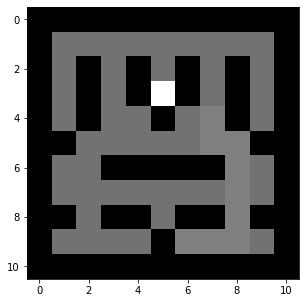

row: 3   col: 7
X: 251.8   Y: -56.150000000000006   Z: 40


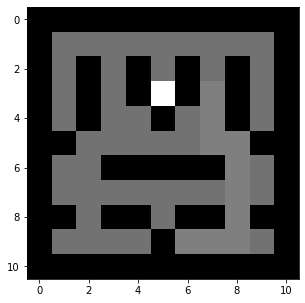

row: 2   col: 7
X: 271.2   Y: -56.150000000000006   Z: 40


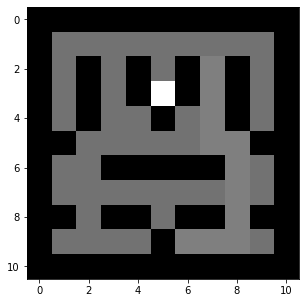

row: 1   col: 7
X: 290.6   Y: -56.150000000000006   Z: 40


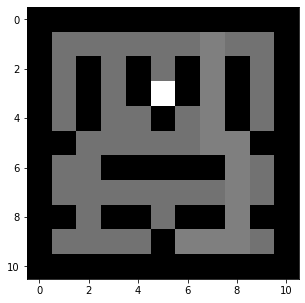

row: 1   col: 6
X: 290.6   Y: -36.69999999999999   Z: 40


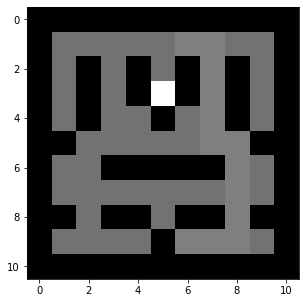

row: 1   col: 5
X: 290.6   Y: -17.25   Z: 40


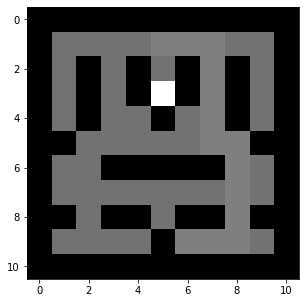

row: 2   col: 5
X: 271.2   Y: -17.25   Z: 40


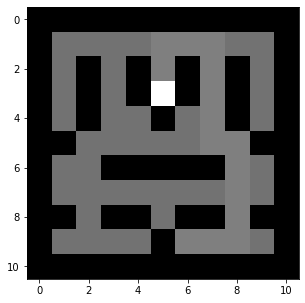

row: 3   col: 5
X: 251.8   Y: -17.25   Z: 40


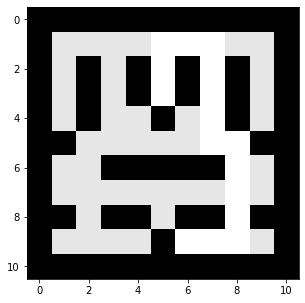

dropoff and end


In [57]:
start = [9,6]

# call create env again to make a new graphing showcase
grid_n = 11
env_testing, actions = create_env_test(grid_n)

state = start[0], start[1]
graph_env(env_testing, state)

# get path
path = get_path_q(start[0], start[1], values)

# go through path
move_bot(path, env_testing)

The above is a visual representation of the path taken

### Take from Drop off Zone and Bring Else where

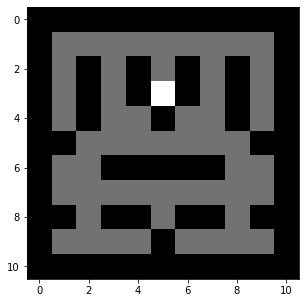

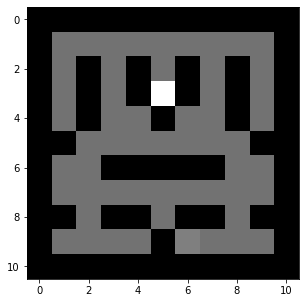

[[(3, 5)], [(2, 5)], [(1, 5)], [(1, 6)], [(1, 7)], [(2, 7)], [(3, 7)], [(4, 7)], [(5, 7)], [(5, 8)], [(6, 8)], [(7, 8)], [(8, 8)], [(9, 8)], [(9, 7)], [(9, 6)]]
Starting...
row: 3   col: 5
X: 251.8   Y: -17.25   Z: 40


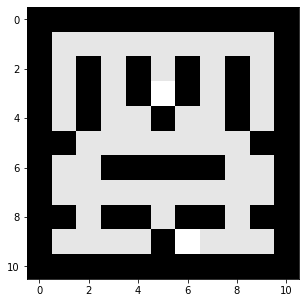

pickup
row: 2   col: 5
X: 271.2   Y: -17.25   Z: 40


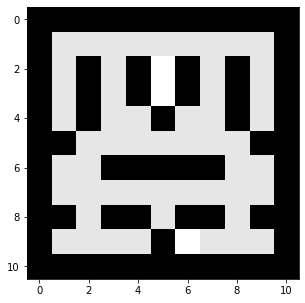

row: 1   col: 5
X: 290.6   Y: -17.25   Z: 40


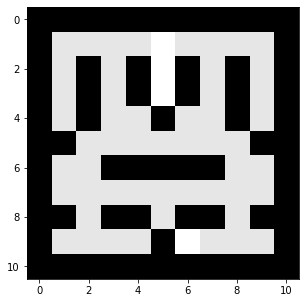

row: 1   col: 6
X: 290.6   Y: -36.69999999999999   Z: 40


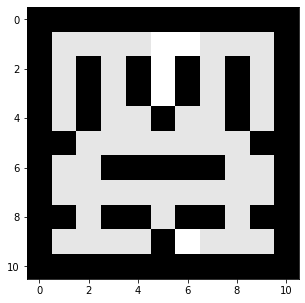

row: 1   col: 7
X: 290.6   Y: -56.150000000000006   Z: 40


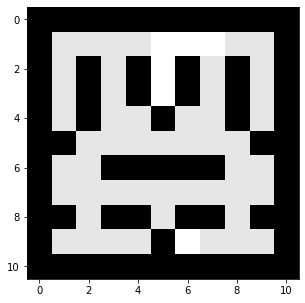

row: 2   col: 7
X: 271.2   Y: -56.150000000000006   Z: 40


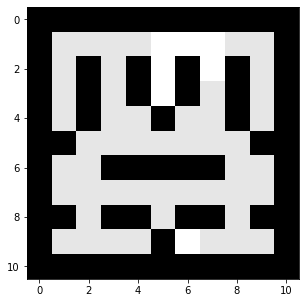

row: 3   col: 7
X: 251.8   Y: -56.150000000000006   Z: 40


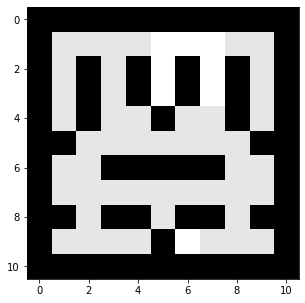

row: 4   col: 7
X: 232.4   Y: -56.150000000000006   Z: 40


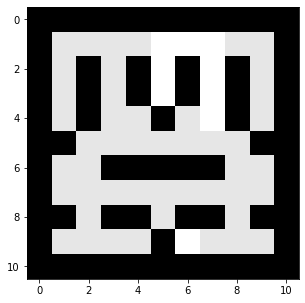

row: 5   col: 7
X: 213.0   Y: -56.150000000000006   Z: 40


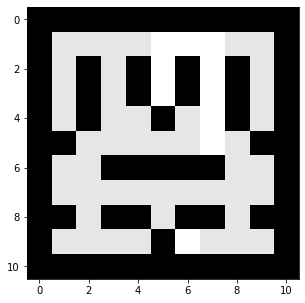

row: 5   col: 8
X: 213.0   Y: -75.6   Z: 40


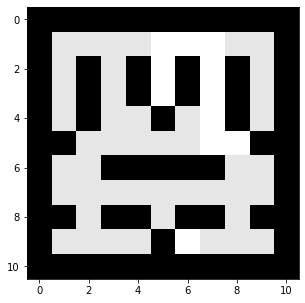

row: 6   col: 8
X: 193.60000000000002   Y: -75.6   Z: 40


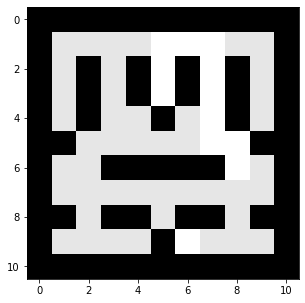

row: 7   col: 8
X: 174.20000000000002   Y: -75.6   Z: 40


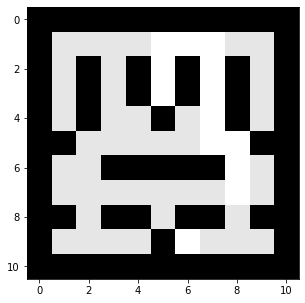

row: 8   col: 8
X: 154.8   Y: -75.6   Z: 40


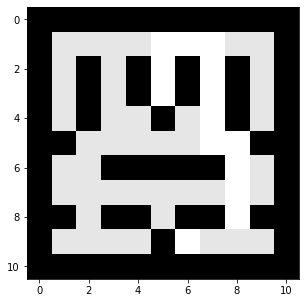

row: 9   col: 8
X: 135.4   Y: -75.6   Z: 40


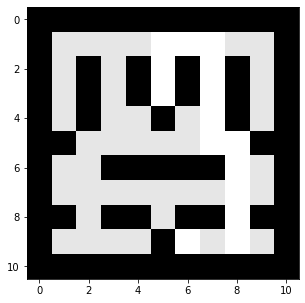

row: 9   col: 7
X: 135.4   Y: -56.150000000000006   Z: 40


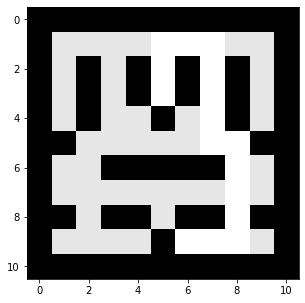

row: 9   col: 6
X: 135.4   Y: -36.69999999999999   Z: 40


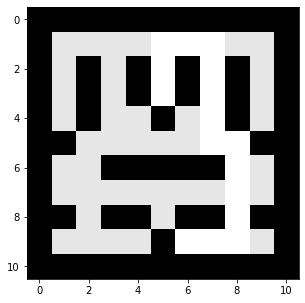

dropoff and end


In [58]:
start = [9,6]

# call create env again to make a new graphing showcase
grid_n = 11
env_testing, actions = create_env_test(grid_n)

state = start[0], start[1]
graph_env(env_testing, state)

# get path
path = get_path_q(start[0], start[1], qp_values)

# To Reverse the process
path = path[::-1]

# go through path
move_bot(path, env_testing)